# Author Information

**Author:** CHUA JINGXUAN

**Taylor's Student ID:** 0365376

**Email:** 0365376@sd.taylors.edu.my

**Note:** This Jupyter Notebook was written by CHUA JINGXUAN. If you find any issues, have questions, or want to provide feedback, please don't hesitate to reach out. Thank you for exploring this notebook!

**Date Written**: 28/07/2024 (MON)

**Last Updated**: 30/07/2024 (TUE)

---
# ITS70804 Text and Image Processing: ASSIGNMENT 3
---

# Trial 04: InceptionV3 (Teacher) + DeiT-Tiny (Student)

# Importing Essential Libraries

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 911.1 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_6

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import torchvision.models as models
import timm
import time
from sklearn.metrics import classification_report, accuracy_score

# 1.0 Data Loading and Apply Augmentation

In [ ]:
def get_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images for DeiT input
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),  # Normalize for CIFAR-10
    ])

# Loading CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=get_transforms())
train_loader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=get_transforms())
test_loader = DataLoader(dataset=test_dataset, batch_size=512, shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 43190325.09it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# 2.0 Instantiate Teacher and Student Model

In [ ]:
# Initialize the teacher model (InceptionV3)
teacher_model = models.inception_v3(pretrained=True)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 10)  # Adjusting the final layer for CIFAR-10
teacher_model = teacher_model.eval()  # Set to evaluation mode

# Initialize the student model (DeiT Tiny)
student_model = timm.create_model('deit_tiny_patch16_224', pretrained=False, num_classes=10)
student_model.train()

# Move models to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model = teacher_model.to(device)
student_model = student_model.to(device)

# Function to count the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters
teacher_params = count_parameters(teacher_model)
student_params = count_parameters(student_model)
print(f"Number of parameters in teacher model (InceptionV3): {teacher_params}")
print(f"Number of parameters in student model (DeiT Tiny): {student_params}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 186MB/s] 


Number of parameters in teacher model (InceptionV3): 25132754
Number of parameters in student model (DeiT Tiny): 5526346


# 3.0 Define Loss Function and Optimizer

In [ ]:
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.0005)  # Adjust learning rate as necessary

def distillation_loss(output, teacher_output, labels, temp=2.0):
    soft_loss = nn.KLDivLoss()(F.log_softmax(output/temp, dim=1), F.softmax(teacher_output/temp, dim=1))
    hard_loss = nn.CrossEntropyLoss()(output, labels)
    return soft_loss + hard_loss

temperature = 3.0  # Temperature used for softening probabilities

# 4.0 Model Training Loop and Timing

In [ ]:
num_epochs = 50
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    student_model.train()
    total_loss = 0
    start_time = time.time() # Start Timing

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            teacher_outputs = teacher_model(images)
        student_outputs = student_model(images)

        loss = distillation_loss(student_outputs, teacher_outputs, labels, temperature)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_duration = time.time() - start_time
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    student_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = student_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    test_accuracies.append(accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, Duration: {epoch_duration:.2f} seconds')

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2976: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 1/50, Loss: 1.8866, Accuracy: 38.50%, Duration: 207.64 seconds
Epoch 2/50, Loss: 1.6236, Accuracy: 43.92%, Duration: 202.38 seconds
Epoch 3/50, Loss: 1.4601, Accuracy: 49.46%, Duration: 202.79 seconds
Epoch 4/50, Loss: 1.3814, Accuracy: 50.82%, Duration: 203.80 seconds
Epoch 5/50, Loss: 1.2892, Accuracy: 55.38%, Duration: 202.62 seconds
Epoch 6/50, Loss: 1.2092, Accuracy: 55.86%, Duration: 202.81 seconds
Epoch 7/50, Loss: 1.1584, Accuracy: 61.56%, Duration: 202.79 seconds
Epoch 8/50, Loss: 1.0844, Accuracy: 61.54%, Duration: 202.99 seconds
Epoch 9/50, Loss: 1.0343, Accuracy: 65.78%, Duration: 202.76 seconds
Epoch 10/50, Loss: 0.9827, Accuracy: 65.40%, Duration: 202.96 seconds
Epoch 11/50, Loss: 0.9428, Accuracy: 66.55%, Duration: 203.32 seconds
Epoch 12/50, Loss: 0.9053, Accuracy: 68.21%, Duration: 203.09 seconds
Epoch 13/50, Loss: 0.8730, Accuracy: 68.17%, Duration: 203.25 seconds
Epoch 14/50, Loss: 0.8418, Accuracy: 68.52%, Duration: 203.75 seconds
Epoch 15/50, Loss: 0.8099, Ac

In [ ]:
torch.save(student_model.state_dict(), './InceptionV3_deit_student.pth')

# 5.0 Evaluate the Model

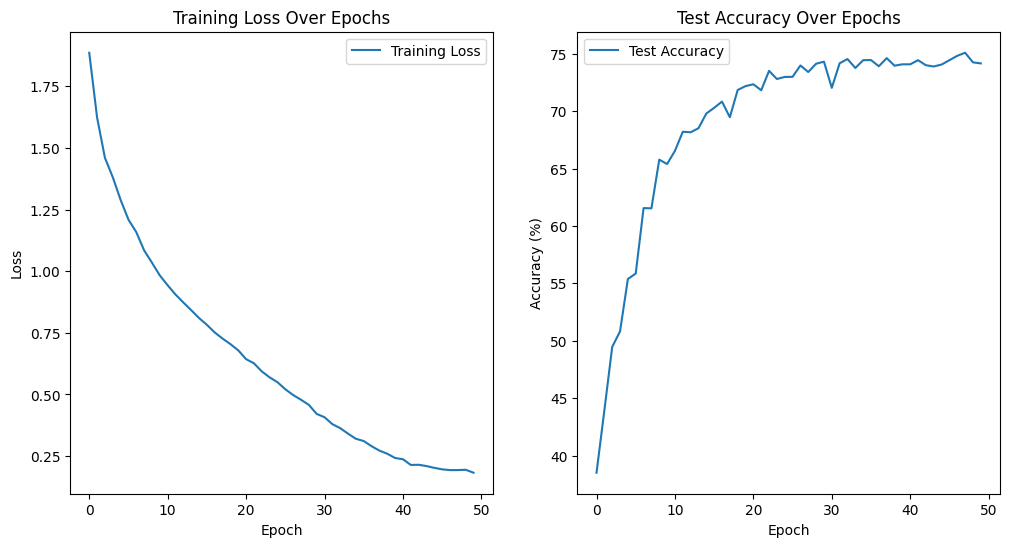

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [ ]:
student_model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = student_model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_targets, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')
print('Classification Report:\n', classification_report(all_targets, all_preds))

Accuracy: 74.49%
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.80      0.76      1000
           1       0.84      0.84      0.84      1000
           2       0.63      0.67      0.65      1000
           3       0.59      0.57      0.58      1000
           4       0.77      0.67      0.72      1000
           5       0.70      0.61      0.65      1000
           6       0.74      0.88      0.80      1000
           7       0.82      0.77      0.79      1000
           8       0.83      0.84      0.84      1000
           9       0.83      0.80      0.81      1000

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000

